In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
import pandas as pd
import os

In [2]:
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/01 16:33:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in data
flights_2018 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2018.parquet')
flights_2019 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2019.parquet')
flights_2020 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2020.parquet')
flights_2021 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2021.parquet')
flights_2022 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2022.parquet')

In [18]:
"""
Transform data so that each row is an airline and each column is a day. 
The value of each cell is the proportion of flights for that airline on that day 
that had an arrival delay >= 15 minutes.
""" 
# Combine all years, select relevant columns, drop missing
combined = flights_2018.union(flights_2019).union(flights_2020).union(flights_2021).union(flights_2022) \
    .select('FlightDate', 'Airline', 'ArrDel15').dropna()

# Group by airline and date, calculate proportion of delayed flights
delay_prop = combined.groupBy('Airline', 'FlightDate') \
                .agg(F.mean('ArrDel15').alias('delay_proportion'))

# Pivot so each airline is a row and each date is a column
pivoted = delay_prop.groupBy('Airline') \
            .pivot('FlightDate') \
            .agg(F.first('delay_proportion')) \
            .orderBy('Airline')

# Fill NA values with 0
data = pivoted.fillna(0)

print(f'Shape of transformed data: {data.count()} rows, {len(data.columns)} columns.')

[Stage 79:======================================================> (29 + 1) / 30]

Shape of transformed data: 28 rows, 1674 columns.


In [38]:
# Create feature vector
feats = data.columns[1:]
assembler = VectorAssembler(inputCols=feats, outputCol='features')
dataset = assembler.transform(data)

# Show 5 rows
dataset.select('features').show(5)

[Stage 1089:====================================================> (29 + 1) / 30]

25/12/01 17:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 1097:>                                                       (0 + 1) / 1]

25/12/01 17:21:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1101:>                                                       (0 + 1) / 1]

25/12/01 17:21:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


AttributeError: 'PipelineModel' object has no attribute 'select'

In [20]:
# Create function to find optimal k
def kmeans_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = kmeans.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

In [21]:
# Loop through various k values and view results
comparison = kmeans_range(2, 10, dataset)
comparison

[Stage 98:======================================================> (29 + 1) / 30]

25/12/01 16:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 16:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 107:=====================================================> (29 + 1) / 30]

25/12/01 16:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 16:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 115:>                                                        (0 + 1) / 1]

25/12/01 16:59:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 16:59:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 155:=====================================================> (29 + 1) / 30]

25/12/01 16:59:31 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 16:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 163:>                                                        (0 + 1) / 1]

25/12/01 16:59:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 167:>                                                        (0 + 1) / 1]

25/12/01 16:59:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 173:=====================================================> (29 + 1) / 30]

25/12/01 16:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 16:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 181:>                                                        (0 + 1) / 1]

25/12/01 16:59:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 187:=====================================================> (29 + 1) / 30]

25/12/01 16:59:44 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 16:59:45 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 195:>                                                        (0 + 1) / 1]

25/12/01 16:59:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 205:=====================================================> (29 + 1) / 30]

25/12/01 16:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 16:59:51 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 213:>                                                        (0 + 1) / 1]

25/12/01 16:59:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 16:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 16:59:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 253:=====================================================> (29 + 1) / 30]

25/12/01 16:59:58 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 16:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 261:>                                                        (0 + 1) / 1]

25/12/01 17:00:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 265:>                                                        (0 + 1) / 1]

25/12/01 17:00:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 271:=====================================================> (29 + 1) / 30]

25/12/01 17:00:05 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:00:06 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 279:>                                                        (0 + 1) / 1]

25/12/01 17:00:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 285:=====================================================> (29 + 1) / 30]

25/12/01 17:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:00:12 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 293:>                                                        (0 + 1) / 1]

25/12/01 17:00:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 303:=====================================================> (29 + 1) / 30]

25/12/01 17:00:17 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 311:>                                                        (0 + 1) / 1]

25/12/01 17:00:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 351:=====================================================> (29 + 1) / 30]

25/12/01 17:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 359:>                                                        (0 + 1) / 1]

25/12/01 17:00:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 363:>                                                        (0 + 1) / 1]

25/12/01 17:00:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 369:=====================================================> (29 + 1) / 30]

25/12/01 17:00:31 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 377:>                                                        (0 + 1) / 1]

25/12/01 17:00:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 383:=====================================================> (29 + 1) / 30]

25/12/01 17:00:38 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:00:38 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 391:>                                                        (0 + 1) / 1]

25/12/01 17:00:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 401:=====================================================> (29 + 1) / 30]

25/12/01 17:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 409:>                                                        (0 + 1) / 1]

25/12/01 17:00:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:00:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:00:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 449:=====================================================> (29 + 1) / 30]

25/12/01 17:00:52 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:00:52 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 457:>                                                        (0 + 1) / 1]

25/12/01 17:00:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 461:>                                                        (0 + 1) / 1]

25/12/01 17:00:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 467:=====================================================> (29 + 1) / 30]

25/12/01 17:00:58 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:00:59 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 475:>                                                        (0 + 1) / 1]

25/12/01 17:01:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 481:=====================================================> (29 + 1) / 30]

25/12/01 17:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:01:05 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 489:>                                                        (0 + 1) / 1]

25/12/01 17:01:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 499:=====================================================> (29 + 1) / 30]

25/12/01 17:01:10 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 507:>                                                        (0 + 1) / 1]

25/12/01 17:01:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:01:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 547:=====================================================> (29 + 1) / 30]

25/12/01 17:01:18 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:01:19 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 555:>                                                        (0 + 1) / 1]

25/12/01 17:01:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/01 17:01:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 565:=====================================================> (29 + 1) / 30]

25/12/01 17:01:25 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:01:25 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 573:>                                                        (0 + 1) / 1]

25/12/01 17:01:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 579:=====================================================> (29 + 1) / 30]

25/12/01 17:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 587:>                                                        (0 + 1) / 1]

25/12/01 17:01:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 597:=====================================================> (29 + 1) / 30]

25/12/01 17:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 605:>                                                        (0 + 1) / 1]

25/12/01 17:01:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:01:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:01:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 645:=====================================================> (29 + 1) / 30]

25/12/01 17:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 653:>                                                        (0 + 1) / 1]

25/12/01 17:01:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 657:=========================================================(1 + 0) / 1]

25/12/01 17:01:47 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 663:=====================================================> (29 + 1) / 30]

25/12/01 17:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 671:>                                                        (0 + 1) / 1]

25/12/01 17:01:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 677:=====================================================> (29 + 1) / 30]

25/12/01 17:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 685:>                                                        (0 + 1) / 1]

25/12/01 17:01:58 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 695:=====================================================> (29 + 1) / 30]

25/12/01 17:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 703:>                                                        (0 + 1) / 1]

25/12/01 17:02:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:02:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 748:=====================================================> (29 + 1) / 30]

25/12/01 17:02:10 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 756:>                                                        (0 + 1) / 1]

25/12/01 17:02:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 760:>                                                        (0 + 1) / 1]

25/12/01 17:02:13 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 766:=====================================================> (29 + 1) / 30]

25/12/01 17:02:17 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 774:>                                                        (0 + 1) / 1]

25/12/01 17:02:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 780:=====================================================> (29 + 1) / 30]

25/12/01 17:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 788:>                                                        (0 + 1) / 1]

25/12/01 17:02:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 798:=====================================================> (29 + 1) / 30]

25/12/01 17:02:29 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:02:29 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 806:>                                                        (0 + 1) / 1]

25/12/01 17:02:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:02:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 841:=====================================================> (29 + 1) / 30]

25/12/01 17:02:36 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:02:37 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 849:>                                                        (0 + 1) / 1]

25/12/01 17:02:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/01 17:02:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 859:=====================================================> (29 + 1) / 30]

25/12/01 17:02:43 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:02:44 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 867:>                                                        (0 + 1) / 1]

25/12/01 17:02:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 873:=====================================================> (29 + 1) / 30]

25/12/01 17:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 881:>                                                        (0 + 1) / 1]

25/12/01 17:02:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 891:=====================================================> (29 + 1) / 30]

25/12/01 17:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 899:>                                                        (0 + 1) / 1]

25/12/01 17:02:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:02:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 934:=====================================================> (29 + 1) / 30]

25/12/01 17:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 942:>                                                        (0 + 1) / 1]

25/12/01 17:03:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 946:>                                                        (0 + 1) / 1]

25/12/01 17:03:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 952:=====================================================> (29 + 1) / 30]

25/12/01 17:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 960:>                                                        (0 + 1) / 1]

25/12/01 17:03:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 966:=====================================================> (29 + 1) / 30]

25/12/01 17:03:15 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:03:16 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 974:>                                                        (0 + 1) / 1]

25/12/01 17:03:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


,k,silhouette
0,2,0.628521
1,3,0.271279
2,4,0.314954
3,5,0.076371
4,6,0.121820
5,7,0.145285
6,8,0.215435
7,9,0.087252
8,10,0.125590


In [22]:
comparison

,k,silhouette
0,2,0.628521
1,3,0.271279
2,4,0.314954
3,5,0.076371
4,6,0.121820
5,7,0.145285
6,8,0.215435
7,9,0.087252
8,10,0.125590


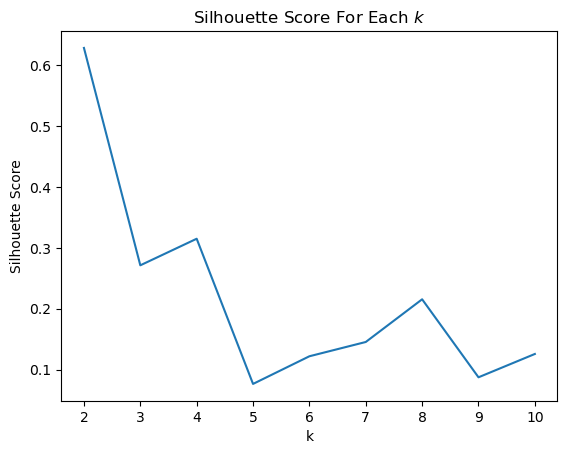

In [23]:
# Visualize
import matplotlib.pyplot as plt
x=comparison.k
y=comparison.silhouette

plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each $k$')
plt.show()

In [24]:
# Refit with k=2
kmeans = KMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model = kmeans.fit(dataset)
        
# Predict
preds = model.transform(dataset)

[Stage 984:=====================================================> (29 + 1) / 30]

25/12/01 17:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1469.9 KiB


25/12/01 17:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1471.8 KiB


[Stage 992:>                                                        (0 + 1) / 1]

25/12/01 17:09:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/01 17:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/01 17:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1032:====================================================> (29 + 1) / 30]

25/12/01 17:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 1040:>                                                       (0 + 1) / 1]

25/12/01 17:09:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1044:>                                                       (0 + 1) / 1]

25/12/01 17:09:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [27]:
preds.select('Airline', 'prediction').show(30, truncate=False)

[Stage 1063:====================================================> (29 + 1) / 30]

25/12/01 17:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 1071:>                                                       (0 + 1) / 1]

25/12/01 17:11:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+-----------------------------------------+----------+
|Airline                                  |prediction|
+-----------------------------------------+----------+
|Air Wisconsin Airlines Corp              |0         |
|Alaska Airlines Inc.                     |0         |
|Allegiant Air                            |0         |
|American Airlines Inc.                   |0         |
|Cape Air                                 |0         |
|Capital Cargo International              |0         |
|Comair Inc.                              |0         |
|Commutair Aka Champlain Enterprises, Inc.|0         |
|Compass Airlines                         |0         |
|Delta Air Lines Inc.                     |0         |
|Empire Airlines Inc.                     |0         |
|Endeavor Air Inc.                        |0         |
|Envoy Air                                |0         |
|ExpressJet Airlines Inc.         

#### So with $k=2$, which has the highest silhouette score, every airline except for Peninsula Airways Inc. was classified in cluster 0. This suggests that Peninsula is an outlier and maybe should be removed.

In [33]:
outlier_data = preds.filter(F.col('prediction') == 1).select('Airline', *feats).toPandas()

[Stage 1076:====================================================> (29 + 1) / 30]

25/12/01 17:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1471.5 KiB


25/12/01 17:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1473.3 KiB


[Stage 1084:>                                                       (0 + 1) / 1]

25/12/01 17:15:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
